In [4]:
import requests
import pandas as pd
from dotenv import load_dotenv
load_dotenv('../05_data_scraping/.env')
import os
from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb()
from dbio import mood_to_db, db_connect
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import koreanize_matplotlib
import time
from konlpy.tag import Mecab
mecab = Mecab()
from nltk.probability import FreqDist
from wordcloud import WordCloud
import re
from datetime import datetime

In [2]:
def string_delete(text) :
    return text.replace("<b>","").replace("</b>", "").replace("&quot;", "")

def parse_date(date_str):
    # 날짜 문자열을 datetime 객체로 변환
    return datetime.strptime(date_str, "%Y%m%d")

def make_df(df_name) :
    for i in df_name :
        for idx in range(0, len(df_name[i])) : 
            df_name[i][idx] = string_delete(df_name[i][idx])
    df_name['postdate'] = df_name['postdate'].apply(parse_date)
    return df_name
def extract_words(words_list) : 
    return [word for word, pos in words_list if pos in target]

## 성수/10만개/정확도순/명사만

In [7]:
client_id = os.getenv('client_id') # 환경 변수에 접근
client_pw = os.getenv('client_pw') # 환경 변수에 접근

url = "https://openapi.naver.com/v1/search/blog.json"
final_data_sungsu = pd.DataFrame()
start = time.time() # 시작
for i in range(1, 1001) : 
    payload = {'query' : '성수', 'display' : 100, 'start' : i, 'sort' : 'sim'}
    headers = {'X-Naver-Client-Id' : client_id, 'X-Naver-Client-Secret' : client_pw}
    r = requests.get(url, params = payload, headers = headers)
    if r.status_code == 200 :
        data = r.json()
    else :
        print("Error Code:", r.status_code)
        
    
    df_sungsu_sim = pd.json_normalize(data['items'])
    entire_data_sungsu_sim = make_df(df_sungsu_sim)
    final_data_sungsu = pd.concat([final_data_sungsu, entire_data_sungsu_sim], ignore_index=True)
print(final_data_sungsu)
print(f"{time.time()-start:.4f} sec")

                                   title  \
0           성수동 카페거리 할아버지공장 성수역 대형 카페 추천   
1            [성수속눈썹펌] 속눈썹펌 잘하는곳 스튜디오 에트나   
2        성수동 미용실 샵위드 성수본점, 가을겨울맞이 브라운 염색   
3                        성수 핫플 맛집 자연도소금빵   
4              성수 서울숲 맛집 초밥은 기본 우니까지 맛있게   
...                                  ...   
99995    [성수카페추천 유아왓유잇] 라이스 베이스드 비건 성수팝업   
99996  무신사스토어 성수 @대림창고 매장, 2024 가을패션...    
99997   서울 성수나들이 ; 할아버지공장카페, 편안한 분위기가 좋아   
99998            성수 분위기 좋은 칵테일바 위스키바 조디악   
99999   무신사 스토어 성수 @대림창고 성수동 핫플 가을 패션 완성   

                                                   link  \
0      https://blog.naver.com/qkrgkdms1993/223637437253   
1          https://blog.naver.com/sssomina/223635003523   
2          https://blog.naver.com/songxxxx/223637484628   
3            https://blog.naver.com/roddl2/223634566375   
4          https://blog.naver.com/hohobaby/223631358628   
...                                                 ...   
99995   https://blog.naver.com/blk_lg_ryan/223616282386   

In [12]:
start = time.time() # 시작
final_data_sungsu = final_data_sungsu[['title', 'postdate']]
final_data_sungsu['title2'] = final_data_sungsu['title'].apply(lambda x : mecab.nouns(x))
print(final_data_sungsu.head())
print(f"{time.time()-start:.4f} sec")

                             title   postdate  \
0     성수동 카페거리 할아버지공장 성수역 대형 카페 추천 2024-10-28   
1      [성수속눈썹펌] 속눈썹펌 잘하는곳 스튜디오 에트나 2024-10-27   
2  성수동 미용실 샵위드 성수본점, 가을겨울맞이 브라운 염색 2024-10-29   
3                  성수 핫플 맛집 자연도소금빵 2024-10-26   
4        성수 서울숲 맛집 초밥은 기본 우니까지 맛있게 2024-10-24   

                                         title2  
0       [성수동, 카페, 거리, 할아버지, 공장, 수역, 대형, 카페, 추천]  
1                 [성수, 속눈썹, 펌, 속눈썹, 펌, 곳, 스튜디오]  
2  [성수동, 미용실, 샵, 위드, 성수, 본점, 가을, 겨울맞이, 브라운, 염색]  
3                     [성수, 핫, 플, 맛집, 자연, 소금, 빵]  
4                     [성수, 서울숲, 맛집, 초밥, 기본, 우니]  
3.1864 sec


In [7]:
word_list_sungsu = []
for i in final_data_sungsu['title2'] : 
    for j in i :
        if j not in stopwords_sungsu :
            word_list_sungsu.append(j)
len(word_list_sungsu)

645323

<Axes: xlabel='Samples', ylabel='Counts'>

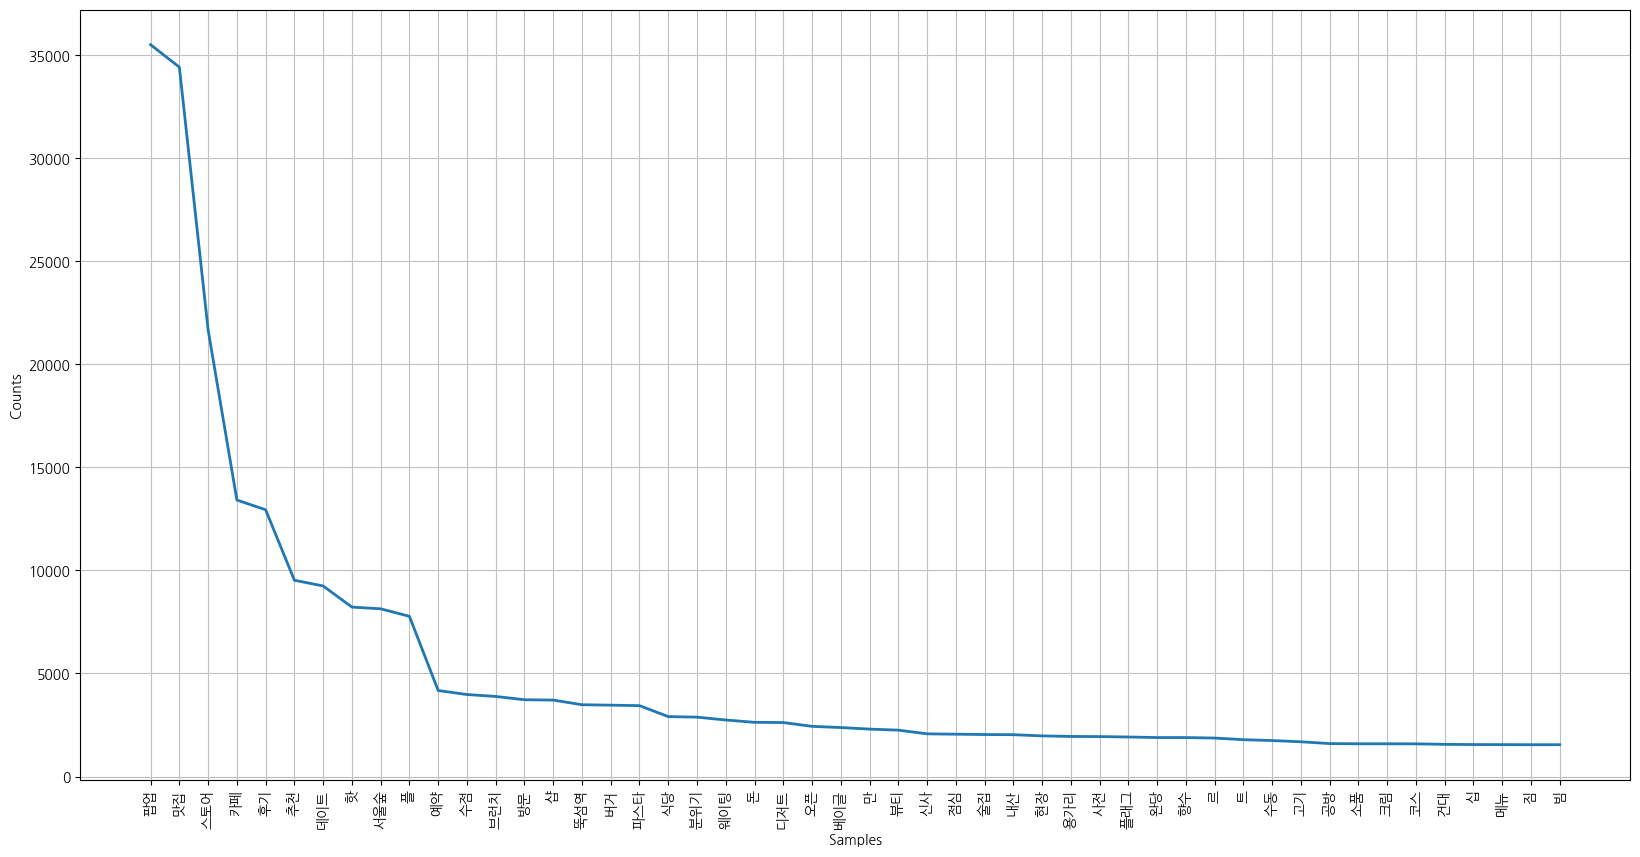

In [8]:
plt.figure(figsize = (20,10))
FreqDist(word_list_sungsu).plot(50)

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

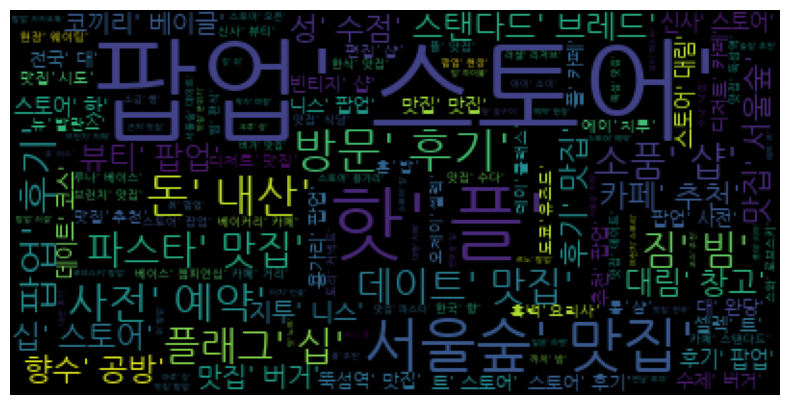

In [9]:
plt.figure(figsize = (10, 5))
wc_sungsu = WordCloud(font_path = '/user/share/fonts/truetype/nanum/NanumGothic.ttf').generate(str(word_list_sungsu))
plt.imshow(wc_sungsu)
plt.axis('off')

### 형태소_morphs

In [13]:
# final_data_sungsu_morphs = final_data_sungsu.copy()
final_data_sungsu_pos = final_data_sungsu.copy()

In [14]:
# final_data_sungsu_morphs = final_data_sungsu_morphs.drop('title2', axis = 1)
final_data_sungsu_pos = final_data_sungsu_pos.drop('title2', axis = 1)

In [15]:
# final_data_sungsu_morphs['title2'] = final_data_sungsu_morphs['title'].apply(lambda x: mecab.morphs(re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x)))
final_data_sungsu_pos['title2'] = final_data_sungsu_pos['title'].apply(lambda x: mecab.pos(re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x)))

#### stopwords

In [28]:
stopwords_sungsu = pd.read_csv('https://raw.githubusercontent.com/haram4th/ablearn/main/%ED%95%9C%EA%B5%AD%EC%96%B4%EB%B6%88%EC%9A%A9%EC%96%B4100.txt', header = None)
stopwords_sungsu

0
0     이
1     있
2     하
3     것
4     들
..   ..
104   원
105   잘
106  통하
107  소리
108   놓

[109 rows x 1 columns]

In [29]:
ex_stop_words = ['사람', '집', '시간', '여자', '생각']

In [30]:
for i in ex_stop_words : 
    stopwords_sungsu = stopwords_sungsu.drop(stopwords_sungsu[stopwords_sungsu[0] == i].index)

In [31]:
stopwords_sungsu.reset_index(drop=True, inplace=True)

In [32]:
stopwords_sungsu

0
0     이
1     있
2     하
3     것
4     들
..   ..
99    원
100   잘
101  통하
102  소리
103   놓

[104 rows x 1 columns]

### stopwords도 잘 안빠지고 pos랑 결과가 큰 차이가 없다면 굳이 morph로 하지 않기

### 형태소_pos

In [17]:
final_data_sungsu_pos

title   postdate  \
0           성수동 카페거리 할아버지공장 성수역 대형 카페 추천 2024-10-28   
1            [성수속눈썹펌] 속눈썹펌 잘하는곳 스튜디오 에트나 2024-10-27   
2        성수동 미용실 샵위드 성수본점, 가을겨울맞이 브라운 염색 2024-10-29   
3                        성수 핫플 맛집 자연도소금빵 2024-10-26   
4              성수 서울숲 맛집 초밥은 기본 우니까지 맛있게 2024-10-24   
...                                  ...        ...   
99995    [성수카페추천 유아왓유잇] 라이스 베이스드 비건 성수팝업 2024-10-12   
99996  무신사스토어 성수 @대림창고 매장, 2024 가을패션...  2024-09-21   
99997   서울 성수나들이 ; 할아버지공장카페, 편안한 분위기가 좋아 2024-09-19   
99998            성수 분위기 좋은 칵테일바 위스키바 조디악 2024-08-29   
99999   무신사 스토어 성수 @대림창고 성수동 핫플 가을 패션 완성 2024-09-17   

                                                  title2  
0      [(성수동, NNP), (카페, NNG), (거리, NNG), (할아버지, NNG)...  
1      [(성수, NNG), (속눈썹, NNG), (펌, NNG), (속눈썹, NNG), ...  
2      [(성수동, NNP), (미용실, NNG), (샵, NNP), (위드, NNP), ...  
3      [(성수, NNG), (핫, NNG), (플, NNG), (맛집, NNG), (자연...  
4      [(성수, NNP), (서울숲, NNP), (맛집, NNG), (초밥, NNG), ...  
...                                                  ...  
99995  [(성수, NNG), (카페, NNG), (추천, NNG), (유아, NNG), (...  
99996  [(무, XPN), (신사, NNG), (스토어, NNG), (성수, NNG), (...  
99997  [(서울, NNP), (성수, NNG), (나, NP), (들, XSN), (이, ...  
99998  [(성수, NNG), (분위기, NNG), (좋, VA), (은, ETM), (칵테...  
99999  [(무, XPN), (신사, NNG), (스토어, NNG), (성수, NNG), (...  

[100000 rows x 3 columns]

In [18]:
target = 'NNG', 'NNP', 'MAG', 'XR', 'NR', 'VV', 'VA', 'VCP', 'VCN', 'MM', 'IC', 'XPN', 'UNKNOWN'

In [19]:
def extract_words(words_list) : 
    return [word for word, pos in words_list if pos in target]

In [20]:
# 특정 형태소만 가져오기
final_data_sungsu_pos['filtered'] = final_data_sungsu_pos['title2'].apply(lambda x : extract_words(x))
final_data_sungsu_pos

title   postdate  \
0           성수동 카페거리 할아버지공장 성수역 대형 카페 추천 2024-10-28   
1            [성수속눈썹펌] 속눈썹펌 잘하는곳 스튜디오 에트나 2024-10-27   
2        성수동 미용실 샵위드 성수본점, 가을겨울맞이 브라운 염색 2024-10-29   
3                        성수 핫플 맛집 자연도소금빵 2024-10-26   
4              성수 서울숲 맛집 초밥은 기본 우니까지 맛있게 2024-10-24   
...                                  ...        ...   
99995    [성수카페추천 유아왓유잇] 라이스 베이스드 비건 성수팝업 2024-10-12   
99996  무신사스토어 성수 @대림창고 매장, 2024 가을패션...  2024-09-21   
99997   서울 성수나들이 ; 할아버지공장카페, 편안한 분위기가 좋아 2024-09-19   
99998            성수 분위기 좋은 칵테일바 위스키바 조디악 2024-08-29   
99999   무신사 스토어 성수 @대림창고 성수동 핫플 가을 패션 완성 2024-09-17   

                                                  title2  \
0      [(성수동, NNP), (카페, NNG), (거리, NNG), (할아버지, NNG)...   
1      [(성수, NNG), (속눈썹, NNG), (펌, NNG), (속눈썹, NNG), ...   
2      [(성수동, NNP), (미용실, NNG), (샵, NNP), (위드, NNP), ...   
3      [(성수, NNG), (핫, NNG), (플, NNG), (맛집, NNG), (자연...   
4      [(성수, NNP), (서울숲, NNP), (맛집, NNG), (초밥, NNG), ...   
...                                                  ...   
99995  [(성수, NNG), (카페, NNG), (추천, NNG), (유아, NNG), (...   
99996  [(무, XPN), (신사, NNG), (스토어, NNG), (성수, NNG), (...   
99997  [(서울, NNP), (성수, NNG), (나, NP), (들, XSN), (이, ...   
99998  [(성수, NNG), (분위기, NNG), (좋, VA), (은, ETM), (칵테...   
99999  [(무, XPN), (신사, NNG), (스토어, NNG), (성수, NNG), (...   

                                             filtered  
0             [성수동, 카페, 거리, 할아버지, 공장, 수역, 대형, 카페, 추천]  
1              [성수, 속눈썹, 펌, 속눈썹, 펌, 잘, 하, 곳, 스튜디오, 트]  
2        [성수동, 미용실, 샵, 위드, 성수, 본점, 가을, 겨울맞이, 브라운, 염색]  
3                           [성수, 핫, 플, 맛집, 자연, 소금, 빵]  
4                       [성수, 서울숲, 맛집, 초밥, 기본, 우니, 맛있]  
...                                               ...  
99995        [성수, 카페, 추천, 유아, 라이스, 베이스, 드, 비, 성수, 팝업]  
99996            [무, 신사, 스토어, 성수, 대림, 창고, 매장, 가을, 패션]  
99997              [서울, 성수, 할아버지, 공장, 카페, 편안, 분위기, 좋]  
99998               [성수, 분위기, 좋, 칵테일, 바, 위스, 키바, 조디악]  
99999  [무, 신사, 스토어, 성수, 대림, 창고, 수동, 핫, 플, 가을, 패션, 완성]  

[100000 rows x 4 columns]

In [21]:
sungsu_pos_word_list = []
for i in final_data_sungsu_pos['filtered'] : 
    for j in i :
        sungsu_pos_word_list.append(j)
len(sungsu_pos_word_list)

860452

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

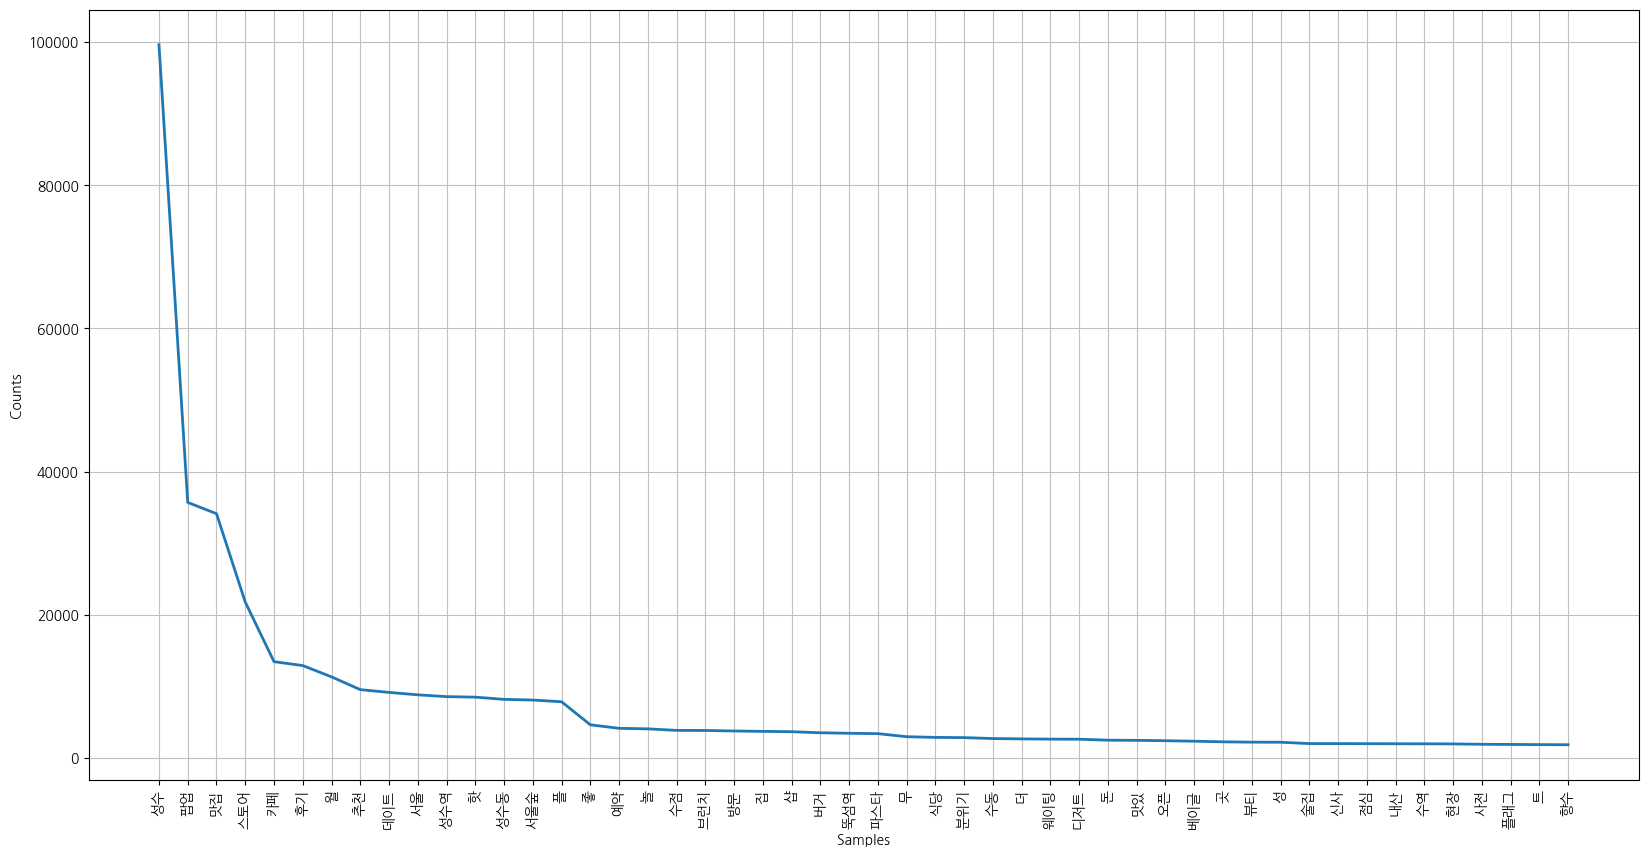

In [22]:
plt.figure(figsize = (20,10))
FreqDist(sungsu_pos_word_list).plot(50)

(-0.5, 399.5, 199.5, -0.5)

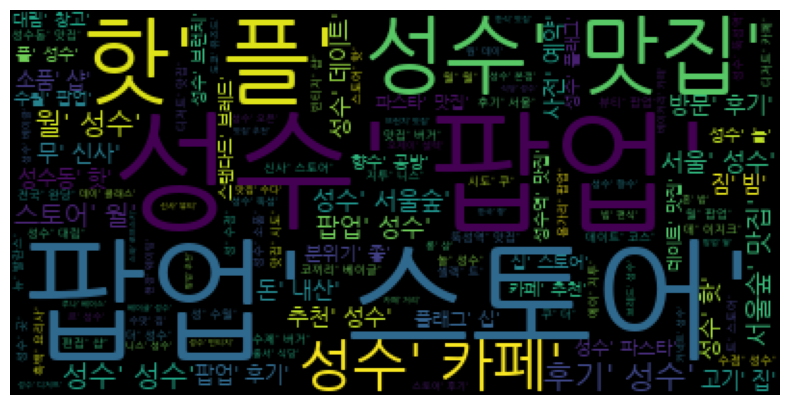

In [23]:
plt.figure(figsize = (10, 5))
wc_sungsu = WordCloud(font_path = '/user/share/fonts/truetype/nanum/NanumGothic.ttf').generate(str(sungsu_pos_word_list))
plt.imshow(wc_sungsu)
plt.axis('off')

#### gensim으로 word2vector 해보기

In [30]:
# !pip install gensim

In [31]:
# !pip install --upgrade numpy

In [24]:
final_data_sungsu_pos['filtered_list'] = final_data_sungsu_pos['filtered'].apply(lambda x : eval(x) if isinstance(x, str) else x)

In [25]:
from gensim.models import Word2Vec
model_sungsu_pos = Word2Vec(final_data_sungsu_pos['filtered_list'], vector_size=100, window=5, min_count=5, workers=8, sg=0)

/home/user/miniforge3/envs/project/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [63]:
model_sungsu_pos_result = model_sungsu_pos.wv.most_similar("성수", topn = 50)
print(model_sungsu_pos_result)

[('서울', 0.3252493441104889), ('플', 0.29801344871520996), ('아지트', 0.28377464413642883), ('퓌', 0.2657627761363983), ('일정', 0.25214919447898865), ('모음', 0.25156721472740173), ('추천', 0.24008134007453918), ('성', 0.22753289341926575), ('트', 0.22261402010917664), ('후기', 0.22127920389175415), ('전부', 0.21703141927719116), ('주말', 0.2151993364095688), ('음식', 0.21464285254478455), ('삼성전자', 0.2142622023820877), ('춥', 0.21169334650039673), ('성수동', 0.21135416626930237), ('무', 0.21126791834831238), ('뚝섬역', 0.2103927582502365), ('수동', 0.21027442812919617), ('데이트', 0.2012328803539276), ('장인', 0.2007361650466919), ('이', 0.2005481868982315), ('플라워', 0.19895438849925995), ('스톤', 0.1981329321861267), ('미디엄', 0.1964150369167328), ('브런치', 0.195330411195755), ('침대', 0.19241897761821747), ('다녀오', 0.19081297516822815), ('핫', 0.18888714909553528), ('즐기', 0.18822160363197327), ('성수역', 0.18756850063800812), ('카페', 0.18657484650611877), ('플레이스', 0.1852928251028061), ('급', 0.18435005843639374), ('더', 0.18346545100212

## 명사만 뺀 거 stopwords 넣어서 word2vec해보기

In [39]:
model_sungsu_noun = Word2Vec(final_data_sungsu['title2'], vector_size=100, window=5, min_count=5, workers=8, sg=0)

In [59]:
model_sungsu_noun_result = model_sungsu_noun.wv.most_similar("성수", topn = 50)
print(model_sungsu_noun_result)

[('후기', 0.26905182003974915), ('수동', 0.2534492313861847), ('서울', 0.251194566488266), ('핫', 0.24978363513946533), ('성수동', 0.2489972859621048), ('우체국', 0.23445218801498413), ('모음', 0.21929490566253662), ('민수', 0.21855156123638153), ('각', 0.21724772453308105), ('브롤', 0.212062269449234), ('드립', 0.20877331495285034), ('만', 0.20725253224372864), ('핸드', 0.20570668578147888), ('아지트', 0.20310193300247192), ('코스', 0.20178306102752686), ('덥', 0.19849234819412231), ('장인', 0.1981668472290039), ('팝업', 0.19242917001247406), ('용가리', 0.1898135393857956), ('삼성전자', 0.18942025303840637), ('플라워', 0.18781641125679016), ('주말', 0.18621289730072021), ('곳', 0.1858251988887787), ('구석구석', 0.18208831548690796), ('일정', 0.18206380307674408), ('시즌', 0.1817479282617569), ('세탁소', 0.18134962022304535), ('예약', 0.17683319747447968), ('아쥬', 0.17649534344673157), ('맥주', 0.17433971166610718), ('브런치', 0.17402927577495575), ('힙', 0.1727399379014969), ('조백', 0.17125873267650604), ('헤이', 0.1703881174325943), ('충족', 0.16889180243

In [47]:
final_data_sungsu.head()

title   postdate  \
0     성수동 카페거리 할아버지공장 성수역 대형 카페 추천 2024-10-28   
1      [성수속눈썹펌] 속눈썹펌 잘하는곳 스튜디오 에트나 2024-10-27   
2  성수동 미용실 샵위드 성수본점, 가을겨울맞이 브라운 염색 2024-10-29   
3                  성수 핫플 맛집 자연도소금빵 2024-10-26   
4        성수 서울숲 맛집 초밥은 기본 우니까지 맛있게 2024-10-24   

                                         title2  
0       [성수동, 카페, 거리, 할아버지, 공장, 수역, 대형, 카페, 추천]  
1                 [성수, 속눈썹, 펌, 속눈썹, 펌, 곳, 스튜디오]  
2  [성수동, 미용실, 샵, 위드, 성수, 본점, 가을, 겨울맞이, 브라운, 염색]  
3                     [성수, 핫, 플, 맛집, 자연, 소금, 빵]  
4                     [성수, 서울숲, 맛집, 초밥, 기본, 우니]

In [50]:
final_data_sungsu['title3'] = final_data_sungsu['title'].apply(lambda x : re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", x))

In [55]:
final_data_sungsu['title3'] = final_data_sungsu['title3'].apply(lambda x : x.split(' '))

In [56]:
model_sungsu_split = Word2Vec(final_data_sungsu['title3'], vector_size=100, window=5, min_count=5, workers=8, sg=0)

In [60]:
model_sungsu_split_result = model_sungsu_split.wv.most_similar("성수동", topn = 50)
print(model_sungsu_split_result)

[('추천', 0.5017144083976746), ('도도한면', 0.4707017242908478), ('성수낙낙점', 0.44273093342781067), ('아구찜에', 0.431128591299057), ('곱창튀김', 0.4195011556148529), ('덥민수', 0.41679736971855164), ('가볼만한곳', 0.41621169447898865), ('플라워', 0.41618552803993225), ('파스타맛집', 0.40682750940322876), ('오키나와', 0.4043801724910736), ('브런치카페', 0.4028417468070984), ('소바식당', 0.40249767899513245), ('치맥', 0.4022502601146698), ('꽃집', 0.3997594118118286), ('부카케', 0.3991151452064514), ('맥주', 0.3960549235343933), ('사전예약링크', 0.395447313785553), ('짐빔편식당', 0.3798460066318512), ('구석구석', 0.37453803420066833), ('힙한', 0.37358006834983826), ('까치화방', 0.3719693422317505), ('퓨전음식', 0.37083134055137634), ('성수빵나오는', 0.36950182914733887), ('에르제', 0.36576616764068604), ('헤이숲', 0.3648507297039032), ('터치포굿', 0.36270299553871155), ('할리데이비슨', 0.36233675479888916), ('헤어', 0.3607630729675293), ('등극할', 0.35724374651908875), ('소금누룩', 0.3566402792930603), ('시간', 0.35597172379493713), ('곁들이기', 0.3554367423057556), ('핫플', 0.35507968068122864), ('새활용'

## 1만개 해보기
- 약 20초 소요

## 유명한 곳, 덜 유명한 곳 10개씩 뽑아서 데이터프레임 만들기

In [11]:
# 유명한 곳 10곳
famous_place = ['명동', '홍대', '강남역', '이태원', '신촌', '여의도', '북촌', '성수', '청담', '연남동']
n_famous_place = ['망원동', '을지로', '성내동', '문래동', '봉천동', '녹사평', '도곡동', '불광동', '장위동', '수색동']

# 컬럼 생성
columns = [
    'date',
    'search_term',
    'word2vec_result',
    'mood_1',
    'mood_1_word',
    'mood_2',
    'mood_2_word',
    'mood_3',
    'mood_3_word',
    'mood_4',
    'mood_4_word',
    'mood_5',
    'mood_5_word',
    'overall_review'
]
# 빈 데이터프레임
famous_mood_df = pd.DataFrame(columns=columns)
n_famous_mood_df = pd.DataFrame(columns=columns)


In [12]:
def string_delete(text) :
    return text.replace("<b>","").replace("</b>", "").replace("&quot;", "")

def parse_date(date_str):
    # 날짜 문자열을 datetime 객체로 변환
    return datetime.strptime(date_str, "%Y%m%d")

def make_df(df_name) :
    for i in df_name :
        for idx in range(0, len(df_name[i])) : 
            df_name[i][idx] = string_delete(df_name[i][idx])
    df_name['postdate'] = df_name['postdate'].apply(parse_date)
    return df_name
    
def w2v(keyword) :
    client_id = os.getenv('client_id') # 환경 변수에 접근
    client_pw = os.getenv('client_pw') # 환경 변수에 접근

    stopwords = pd.read_csv('https://raw.githubusercontent.com/haram4th/ablearn/main/%ED%95%9C%EA%B5%AD%EC%96%B4%EB%B6%88%EC%9A%A9%EC%96%B4100.txt', header = None)
    ex_stop_words = ['사람', '집', '시간']
    for i in ex_stop_words : 
        stopwords = stopwords.drop(stopwords[stopwords[0] == i].index)
    stopwords.reset_index(drop=True, inplace=True)
    
    url = "https://openapi.naver.com/v1/search/blog.json"
    final_data_keyword = pd.DataFrame()
    start = time.time() # 시작
    for i in range(1, 1001) :
        payload = {'query' : keyword, 'display' : 100, 'start' : i, 'sort' : 'sim'}
        headers = {'X-Naver-Client-Id' : client_id, 'X-Naver-Client-Secret' : client_pw}
        r = requests.get(url, params = payload, headers = headers)
        if r.status_code == 200 :
            data = r.json()
        else :
            print("Error Code:", r.status_code)
            
        df_keyword_sim = pd.json_normalize(data['items'])
        entire_data_keyword_sim = make_df(df_keyword_sim)
        final_data_keyword = pd.concat([final_data_keyword, entire_data_keyword_sim], ignore_index=True)
    # print(final_data_keyword)
    final_data_keyword['title2'] = final_data_keyword['title'].apply(lambda x: mecab.pos(re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x)))

    target = 'NNG', 'NNP', 'MAG', 'XR', 'NR', 'VV', 'VA', 'VCP', 'VCN', 'MM', 'IC', 'XPN', 'UNKNOWN'
    def extract_words(words_list) : 
        return [word for word, pos in words_list if pos in target]
    final_data_keyword['filtered'] = final_data_keyword['title2'].apply(lambda x : extract_words(x))
    final_data_keyword['filtered_list'] = final_data_keyword['filtered'].apply(lambda x : eval(x) if isinstance(x, str) else x)
    from gensim.models import Word2Vec
    model_keyword_pos = Word2Vec(final_data_keyword['filtered_list'], vector_size=100, window=5, min_count=5, workers=8, sg=0)
    model_keyword_pos_result = model_keyword_pos.wv.most_similar(keyword, topn = 50)
    print(f"{time.time()-start:.4f} sec")
    return keyword, model_keyword_pos_result

In [13]:
# 유명한 곳 10곳 word2vector하고 데이터프레임으로 만들기
for i in famous_place :
    today = str(datetime.now().strftime('%Y-%m-%d')).replace("-","_")
    keyword, result = w2v(i)
    new_row = {
    'date': today,
    'search_term': keyword,
    'word2vec_result': result,
    'mood_1': '',
    'mood_1_word': '',
    'mood_2': '',
    'mood_2_word': '',
    'mood_3': '',
    'mood_3_word': '',
    'mood_4': '',
    'mood_4_word': '',
    'mood_5': '',
    'mood_5_word': '',
    'overall_review': ''
}
    famous_mood_df = famous_mood_df.append(new_row, ignore_index=True)
print(famous_mood_df)

/home/user/miniforge3/envs/project/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


297.6663 sec


/tmp/ipykernel_31015/506657839.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  famous_mood_df = famous_mood_df.append(new_row, ignore_index=True)


307.1322 sec


/tmp/ipykernel_31015/506657839.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  famous_mood_df = famous_mood_df.append(new_row, ignore_index=True)


309.8403 sec


/tmp/ipykernel_31015/506657839.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  famous_mood_df = famous_mood_df.append(new_row, ignore_index=True)


285.2757 sec


/tmp/ipykernel_31015/506657839.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  famous_mood_df = famous_mood_df.append(new_row, ignore_index=True)


285.2505 sec


/tmp/ipykernel_31015/506657839.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  famous_mood_df = famous_mood_df.append(new_row, ignore_index=True)


295.6997 sec


/tmp/ipykernel_31015/506657839.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  famous_mood_df = famous_mood_df.append(new_row, ignore_index=True)


272.6428 sec


/tmp/ipykernel_31015/506657839.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  famous_mood_df = famous_mood_df.append(new_row, ignore_index=True)


288.8560 sec


/tmp/ipykernel_31015/506657839.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  famous_mood_df = famous_mood_df.append(new_row, ignore_index=True)


283.3242 sec


/tmp/ipykernel_31015/506657839.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  famous_mood_df = famous_mood_df.append(new_row, ignore_index=True)


285.2284 sec
         date search_term                                    word2vec_result  \
0  2024_11_04          명동  [(서울, 0.37311533093452454), (맛집, 0.29711124300...   
1  2024_11_04          홍대  [(추천, 0.3566383123397827), (상수역, 0.29021331667...   
2  2024_11_04         강남역  [(동, 0.3080754578113556), (찾, 0.30423462390899...   
3  2024_11_04         이태원  [(서울, 0.32260534167289734), (진행, 0.29272514581...   
4  2024_11_04          신촌  [(신촌역, 0.37326470017433167), (스, 0.31803068518...   
5  2024_11_04         여의도  [(추천, 0.41630762815475464), (데이트, 0.3639226853...   
6  2024_11_04          북촌  [(코스, 0.40259718894958496), (명소, 0.37478420138...   
7  2024_11_04          성수  [(성수동, 0.3592395484447479), (성, 0.279660373926...   
8  2024_11_04          청담  [(드디어, 0.2554343342781067), (주문, 0.25281032919...   
9  2024_11_04         연남동  [(공연, 0.32659316062927246), (추천, 0.31935122609...   

  mood_1 mood_1_word mood_2 mood_2_word mood_3 mood_3_word mood_4 mood_4_word  \
0                        

/tmp/ipykernel_31015/506657839.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  famous_mood_df = famous_mood_df.append(new_row, ignore_index=True)


In [15]:
famous_mood_df.head(10)

date search_term                                    word2vec_result  \
0  2024_11_04          명동  [(서울, 0.37311533093452454), (맛집, 0.29711124300...   
1  2024_11_04          홍대  [(추천, 0.3566383123397827), (상수역, 0.29021331667...   
2  2024_11_04         강남역  [(동, 0.3080754578113556), (찾, 0.30423462390899...   
3  2024_11_04         이태원  [(서울, 0.32260534167289734), (진행, 0.29272514581...   
4  2024_11_04          신촌  [(신촌역, 0.37326470017433167), (스, 0.31803068518...   
5  2024_11_04         여의도  [(추천, 0.41630762815475464), (데이트, 0.3639226853...   
6  2024_11_04          북촌  [(코스, 0.40259718894958496), (명소, 0.37478420138...   
7  2024_11_04          성수  [(성수동, 0.3592395484447479), (성, 0.279660373926...   
8  2024_11_04          청담  [(드디어, 0.2554343342781067), (주문, 0.25281032919...   
9  2024_11_04         연남동  [(공연, 0.32659316062927246), (추천, 0.31935122609...   

  mood_1 mood_1_word mood_2 mood_2_word mood_3 mood_3_word mood_4 mood_4_word  \
0                                                                               
1                                                                               
2                                                                               
3                                                                               
4                                                                               
5                                                                               
6                                                                               
7                                                                               
8                                                                               
9                                                                               

  mood_5 mood_5_word overall_review  
0                                    
1                                    
2                                    
3                                    
4                                    
5                                    
6                                    
7                                    
8                                    
9

In [39]:
famous_mood_df['word2vec_result'][0]

[('서울', 0.37311533093452454),
 ('맛집', 0.29711124300956726),
 ('추천', 0.29097601771354675),
 ('맞', 0.2906630337238312),
 ('스페셜', 0.2479073703289032),
 ('이펑', 0.24387696385383606),
 ('이유', 0.24110238254070282),
 ('내산', 0.23041124641895294),
 ('늘', 0.23005932569503784),
 ('해외여행', 0.2121252566576004),
 ('롯데', 0.21150478720664978),
 ('분위기', 0.21114414930343628),
 ('거트', 0.2099105268716812),
 ('주기', 0.20802240073680878),
 ('오제', 0.20763538777828217),
 ('비', 0.20622636377811432),
 ('기분', 0.20241518318653107),
 ('디저트', 0.2010449469089508),
 ('내기', 0.19965210556983948),
 ('시흥시', 0.1972179114818573),
 ('데이트', 0.19204258918762207),
 ('먹', 0.19159936904907227),
 ('평일', 0.1911199390888214),
 ('오가와', 0.18909889459609985),
 ('터틀', 0.18863293528556824),
 ('감자전', 0.18833976984024048),
 ('맛있', 0.18734803795814514),
 ('인', 0.18709757924079895),
 ('강원', 0.18581463396549225),
 ('부드럽', 0.18548397719860077),
 ('양고기', 0.18406373262405396),
 ('비밀', 0.18230202794075012),
 ('회식', 0.18105651438236237),
 ('라파', 0.1

In [37]:
famous_mood_df.columns

Index(['date', 'search_term', 'word2vec_result', 'mood_1', 'mood_1_word',
       'mood_2', 'mood_2_word', 'mood_3', 'mood_3_word', 'mood_4',
       'mood_4_word', 'mood_5', 'mood_5_word', 'overall_review'],
      dtype='object')

In [38]:
alter_columns = ['mood_1', 'mood_1_word',
       'mood_2', 'mood_2_word', 'mood_3', 'mood_3_word', 'mood_4',
       'mood_4_word', 'mood_5', 'mood_5_word', 'overall_review']

In [ ]:
for i in (0, 10) :
    for j in alter_columns :
        famous_mood_df.loc[i, j] = 'happy'

In [14]:
# 덜 유명한 곳 10곳 word2vector하고 데이터프레임으로 만들기
for i in n_famous_place :
    today = str(datetime.now().strftime('%Y-%m-%d')).replace("-","_")
    keyword, result = w2v(i)
    new_row = {
    'date': today,
    'search_term': keyword,
    'word2vec_result': result,
    'mood_1': '',
    'mood_1_word': '',
    'mood_2': '',
    'mood_2_word': '',
    'mood_3': '',
    'mood_3_word': '',
    'mood_4': '',
    'mood_4_word': '',
    'mood_5': '',
    'mood_5_word': '',
    'overall_review': ''
}
    n_famous_mood_df = n_famous_mood_df.append(new_row, ignore_index=True)
print(n_famous_mood_df)

278.6458 sec


/tmp/ipykernel_31015/56169206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_famous_mood_df = n_famous_mood_df.append(new_row, ignore_index=True)


282.9080 sec


/tmp/ipykernel_31015/56169206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_famous_mood_df = n_famous_mood_df.append(new_row, ignore_index=True)


265.3112 sec


/tmp/ipykernel_31015/56169206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_famous_mood_df = n_famous_mood_df.append(new_row, ignore_index=True)


273.0523 sec


/tmp/ipykernel_31015/56169206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_famous_mood_df = n_famous_mood_df.append(new_row, ignore_index=True)


267.0528 sec


/tmp/ipykernel_31015/56169206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_famous_mood_df = n_famous_mood_df.append(new_row, ignore_index=True)


260.4836 sec


/tmp/ipykernel_31015/56169206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_famous_mood_df = n_famous_mood_df.append(new_row, ignore_index=True)


270.3862 sec


/tmp/ipykernel_31015/56169206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_famous_mood_df = n_famous_mood_df.append(new_row, ignore_index=True)


265.2535 sec


/tmp/ipykernel_31015/56169206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_famous_mood_df = n_famous_mood_df.append(new_row, ignore_index=True)


260.9194 sec


/tmp/ipykernel_31015/56169206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_famous_mood_df = n_famous_mood_df.append(new_row, ignore_index=True)


252.2420 sec
         date search_term                                    word2vec_result  \
0  2024_11_04         망원동  [(서울, 0.3174930214881897), (벌, 0.3070079088211...   
1  2024_11_04         을지로  [(분위기, 0.33496618270874023), (맛집, 0.3185517787...   
2  2024_11_04         성내동  [(내동, 0.5557294487953186), (특별, 0.335593611001...   
3  2024_11_04         문래동  [(문래, 0.27702224254608154), (핫, 0.266557604074...   
4  2024_11_04         봉천동  [(쭈꾸미, 0.32744652032852173), (예후, 0.3146719634...   
5  2024_11_04         녹사평  [(녹사평역, 0.5512062907218933), (평역, 0.3712259829...   
6  2024_11_04         도곡동  [(곡동, 0.43884047865867615), (냄비, 0.35127651691...   
7  2024_11_04         불광동  [(처음, 0.39524608850479126), (수복, 0.30828458070...   
8  2024_11_04         장위동  [(치매, 0.3289271295070648), (월곡역, 0.29297184944...   
9  2024_11_04         수색동  [(계층, 0.29012182354927063), (실천, 0.27476990222...   

  mood_1 mood_1_word mood_2 mood_2_word mood_3 mood_3_word mood_4 mood_4_word  \
0                        

/tmp/ipykernel_31015/56169206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_famous_mood_df = n_famous_mood_df.append(new_row, ignore_index=True)


In [27]:
n_famous_mood_df.head(10)

date search_term                                    word2vec_result  \
0  2024_11_04         망원동  [(서울, 0.3174930214881897), (벌, 0.3070079088211...   
1  2024_11_04         을지로  [(분위기, 0.33496618270874023), (맛집, 0.3185517787...   
2  2024_11_04         성내동  [(내동, 0.5557294487953186), (특별, 0.335593611001...   
3  2024_11_04         문래동  [(문래, 0.27702224254608154), (핫, 0.266557604074...   
4  2024_11_04         봉천동  [(쭈꾸미, 0.32744652032852173), (예후, 0.3146719634...   
5  2024_11_04         녹사평  [(녹사평역, 0.5512062907218933), (평역, 0.3712259829...   
6  2024_11_04         도곡동  [(곡동, 0.43884047865867615), (냄비, 0.35127651691...   
7  2024_11_04         불광동  [(처음, 0.39524608850479126), (수복, 0.30828458070...   
8  2024_11_04         장위동  [(치매, 0.3289271295070648), (월곡역, 0.29297184944...   
9  2024_11_04         수색동  [(계층, 0.29012182354927063), (실천, 0.27476990222...   

  mood_1 mood_1_word mood_2 mood_2_word mood_3 mood_3_word mood_4 mood_4_word  \
0                                                                               
1                                                                               
2                                                                               
3                                                                               
4                                                                               
5                                                                               
6                                                                               
7                                                                               
8                                                                               
9                                                                               

  mood_5 mood_5_word overall_review  
0                                    
1                                    
2                                    
3                                    
4                                    
5                                    
6                                    
7                                    
8                                    
9

In [36]:
n_famous_mood_df['word2vec_result'][9]

[('계층', 0.29012182354927063),
 ('실천', 0.2747699022293091),
 ('다면', 0.2745870351791382),
 ('스탠드', 0.27182474732398987),
 ('이삿짐', 0.2682432234287262),
 ('역촌', 0.2487596571445465),
 ('벨', 0.23321808874607086),
 ('좌변기', 0.2268604189157486),
 ('정용', 0.22676953673362732),
 ('세척기', 0.2257208526134491),
 ('우방', 0.21353523433208466),
 ('탄탄히', 0.21333879232406616),
 ('층층', 0.20756497979164124),
 ('공장', 0.20731084048748016),
 ('사공', 0.2059171348810196),
 ('평년', 0.20417287945747375),
 ('샤워기', 0.2038259655237198),
 ('팀', 0.19769413769245148),
 ('정말', 0.19654899835586548),
 ('초고압', 0.19483359158039093),
 ('동산동', 0.19233965873718262),
 ('회', 0.190631702542305),
 ('총회', 0.19059547781944275),
 ('용역', 0.18990403413772583),
 ('교체', 0.1892372965812683),
 ('빈집', 0.1888270527124405),
 ('동전기', 0.18850009143352509),
 ('어떻게', 0.18746039271354675),
 ('불광', 0.18632647395133972),
 ('북아현동', 0.18467427790164948),
 ('파출부', 0.1814493089914322),
 ('내시경', 0.1793377548456192),
 ('접수', 0.1745157092809677),
 ('돌아가', 0.174